In [1]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)

import catboost
from catboost import *
from catboost import CatBoostClassifier, Pool, metrics, cv
from catboost.utils import get_roc_curve, get_confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

# other things: from sklearn.model_selection import StratifiedShuffleSplit 

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, ShuffleSplit
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, recall_score, f1_score, confusion_matrix, precision_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

import shap 

import functions 

In [2]:
# initial auc score 
initial_auc = 0.8986914159732593

best_model_params = {
    'loss_function': 'CrossEntropy', 
    'iterations': 1000,
    'depth': 4,
    'learning_rate': 0.1,
    'eval_metric': 'AUC:hints=skip_train~false',
    # 'eval_metric': metrics.AUC(),
    'custom_metric' : ['Logloss', 'Accuracy', 'AUC:hints=skip_train~false'],
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True
}


In [3]:
df = pd.read_csv('/Users/varyabazilova/Desktop/alluvial_fans/final/!!_050723_cathments_data.csv', index_col = 0)
df = df[df['area_m2'] > 1000]


df = df.drop(['x_wgs', 'y_wgs', 'id'], axis = 1)

morphometry = ['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median', 
               'target', 'M', 'circularity_ratio', 'compactness']

climate = ['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median',
           'max_annualsum_tp', 'n_rainydays_median', 'precip95', 'cross_zero',
           'frost_days', 'tp', 'snow', 'rain', 'veg_frac', 'target', 'M',
           'circularity_ratio', 'compactness', 'mean_annual_t2m_downsc',
           'cont_permafrost', 'glacier']


# climate = ['target', 'perim_m', 'area_m2', 'elv_range', 'cross_zero', 'snow', 'mean_annual_t2m_downsc', 'max_annualsum_tp', 'cont_permafrost', 'glacier']

morphometry = df[morphometry]
climate = df[climate]


In [4]:

# df.to_csv('/Users/varyabazilova/Desktop/alluvial_fans/reviews/new_text_final/!!20240830_cathments_data.csv')

# 1. climate model part 

In [5]:

y = climate.target
X = climate.drop(columns=['target'])

# # # what values are categorical: 
X['glacier'] = X['glacier'].astype(str) 
X['cont_permafrost'] = X['cont_permafrost'].astype(str)
# X['region'] = X['region'].astype(str)

cat_features = list(['cont_permafrost', 'glacier'])#, 'region'])

seed = 42
test_size = 0.3

# climate info, stratified sampling 

In [6]:
model, auc10, accuracy10, confusion_matrix10 = functions.strat_split_data_make_model_save_metrics(X=X, y=y, cat_features=cat_features, 
                                         seed = 42, n_splits=10, model_params=best_model_params)

modelC1, aucC1, accuracyC1, confusion_matrixC1 = functions.strat_split_data_make_model_save_metrics(X=X, y=y, cat_features=cat_features, 
                                         seed = 42, n_splits=1, model_params=best_model_params)



In [7]:
confusion_matrixC1
# np.array(aucC1)

[array([[174,  45],
        [ 43, 276]])]

In [8]:
print('auc1 clim dataset:', np.round(aucC1, 3))
print('acuracy1 clim dataset:', np.round(accuracyC1, 3))


auc1 clim dataset: [0.909]
acuracy1 clim dataset: [0.836]


In [9]:

# data split:
climate['target'].value_counts()

# random guess:  
print('random guess chanses with this data split: %.2f%%' % (1068/len(df) * 100)) #df/total 

random guess chanses with this data split: 59.56%


# climate info, regular sampling 

In [10]:
model, aucReg10, accuracyReg10 = functions.split_data_make_model_save_metrics(X=X, y=y, cat_features=cat_features, 
                                         seed = 42, n_splits=10, model_params=best_model_params)

model, aucReg1, accuracyREG1 = functions.split_data_make_model_save_metrics(X=X, y=y, cat_features=cat_features, 
                                         seed = 42, n_splits=1, model_params=best_model_params)



### plot together to argue why we change the model: it is better to use stratified sampling to preserve the ratio of the class into in the train/test split

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


[Text(0, 0.8400000000000001, '0.84'),
 Text(0, 0.8600000000000001, '0.86'),
 Text(0, 0.8800000000000001, '0.88'),
 Text(0, 0.9, '0.9'),
 Text(0, 0.92, '0.92'),
 Text(0, 0.9400000000000001, '0.94'),
 Text(0, 0.9600000000000001, '0.96'),
 Text(0, 0.9800000000000001, '0.98'),
 Text(0, 1.0, '1.0')]

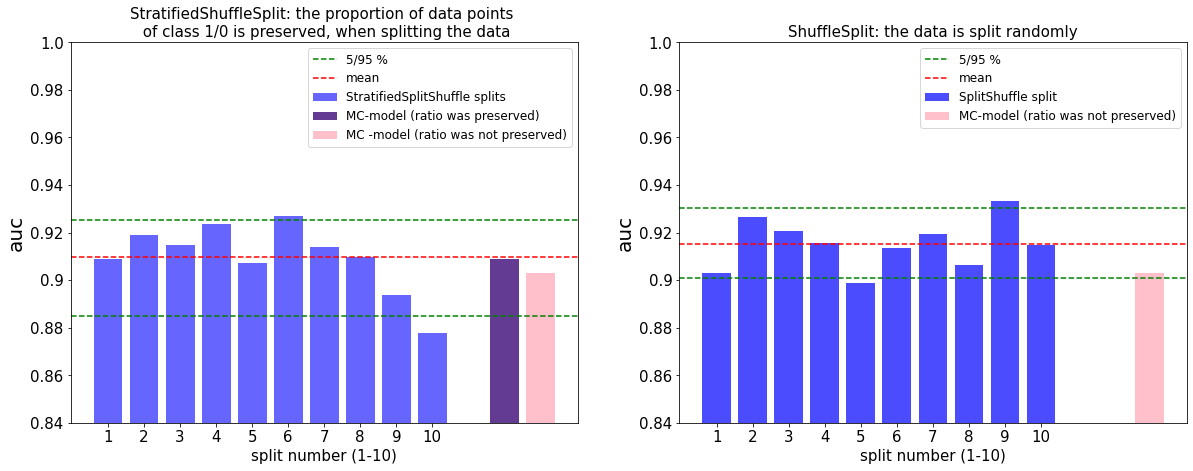

In [11]:
fig = plt.figure(figsize=(20, 7))
mosaic = fig.subplot_mosaic('''
                            ab
                            ''')
# stratified sampling
mosaic['a'].bar(range(1, len(auc10) + 1), auc10, color='blue', alpha=0.6, label = 'StratifiedSplitShuffle splits')
mosaic['a'].bar(x = 12, height = aucC1, color = plt.cm.PuOr(0.9), alpha = 0.9, label = 'MC-model (ratio was preserved)')
# mosaic['a'].bar(x = 13, height = initial_auc, color = 'pink', label = 'initial (old) model (ratio was not preserved)')
mosaic['a'].bar(x = 13, height = aucReg1, color = 'pink', label = 'MC -model (ratio was not preserved)')

mosaic['a'].axhline(y=np.percentile(auc10, 95), color='green', linestyle = '--', label = '5/95 %')
mosaic['a'].axhline(y=np.percentile(auc10, 5), color='green', linestyle = '--')
mosaic['a'].axhline(y=np.mean(auc10), color = 'red', linestyle = '--', label = 'mean')



# regular sampling
mosaic['b'].bar(range(1, len(aucReg10) + 1), aucReg10, color='blue', alpha=0.7, label = 'SplitShuffle split')
# mosaic['b'].bar(x = 12, height = aucC1, color = 'orange', label = 'new model with ')
mosaic['b'].bar(x = 13, height = aucReg1, color = 'pink', label = 'MC-model (ratio was not preserved)')

mosaic['b'].axhline(y=np.percentile(aucReg10, 95), color='green', linestyle = '--', label = '5/95 %')
mosaic['b'].axhline(y=np.percentile(aucReg10, 5), color='green', linestyle = '--')
mosaic['b'].axhline(y=np.mean(aucReg10), color = 'red', linestyle = '--', label = 'mean')


# mosaic['a'].set_ylim(0.875, 1) 
# mosaic['b'].set_ylim(0.875, 1) 
# mosaic['a'].legend(fontsize=12)
# mosaic['b'].legend(fontsize=12)


# mosaic['a'].set_title('StratifiedShuffleSplit: the proportion of data points \n of class 1/0 is preserved, when splitting the data', fontsize = 15)
# mosaic['b'].set_title('ShuffleSplit: the data is split randomly', fontsize = 15)

# mosaic['a'].set_xticks(range(1, len(aucReg10) + 1), fontsize = 15)
# mosaic['b'].set_xticks(range(1, len(aucReg10) + 1), fontsize = 15)

# mosaic['a'].set_ylabel('auc', fontsize = 20)
# mosaic['b'].set_ylabel('auc', fontsize = 20)


# mosaic['a'].set_xlabel('split number (1-10)', fontsize = 15)
# mosaic['b'].set_xlabel('split number (1-10)', fontsize = 15)






mosaic['a'].set_ylim(0.84, 1) 
mosaic['b'].set_ylim(0.84, 1) 
mosaic['a'].legend(fontsize=12)
mosaic['b'].legend(fontsize=12)


mosaic['a'].set_title('StratifiedShuffleSplit: the proportion of data points \n of class 1/0 is preserved, when splitting the data', fontsize = 15)
mosaic['b'].set_title('ShuffleSplit: the data is split randomly', fontsize = 15)

mosaic['a'].set_xticks(range(1, len(aucReg10) + 1))#, fontsize = 20)
mosaic['b'].set_xticks(range(1, len(aucReg10) + 1))#, fontsize = 20)
mosaic['a'].set_xticklabels(range(1, len(aucReg10) + 1), fontsize=15)
mosaic['b'].set_xticklabels(range(1, len(aucReg10) + 1), fontsize=15)


mosaic['a'].set_ylabel('auc', fontsize = 15)
mosaic['b'].set_ylabel('auc', fontsize = 15)


mosaic['a'].set_xlabel('split number (1-10)', fontsize = 15)
mosaic['b'].set_xlabel('split number (1-10)', fontsize = 15)



mosaic['a'].set_ylabel('auc', fontsize = 20)
mosaic['b'].set_ylabel('auc', fontsize = 20)


mosaic['a'].set_xlabel('split number (1-10)', fontsize = 15)
mosaic['b'].set_xlabel('split number (1-10)', fontsize = 15)

mosaic['a'].set_yticklabels(labels=np.round(np.arange(0.84, 1.02, 0.02), 2), fontsize=15)
mosaic['b'].set_yticklabels(labels=np.round(np.arange(0.84, 1.02, 0.02), 2), fontsize=15)







# plt.show()

# plt.savefig('out/removed_points/StratifiedShuffleSplit_together_with_regular_paper_MC_model.png', dpi = 300, bbox_inches = 'tight')

In [12]:
aucC1

[0.9088833540888335]

FixedFormatter should only be used together with FixedLocator


[Text(0, 0.8400000000000001, '0.84'),
 Text(0, 0.8600000000000001, '0.86'),
 Text(0, 0.8800000000000001, '0.88'),
 Text(0, 0.9, '0.9'),
 Text(0, 0.92, '0.92'),
 Text(0, 0.9400000000000001, '0.94'),
 Text(0, 0.9600000000000001, '0.96'),
 Text(0, 0.9800000000000001, '0.98'),
 Text(0, 1.0, '1.0')]

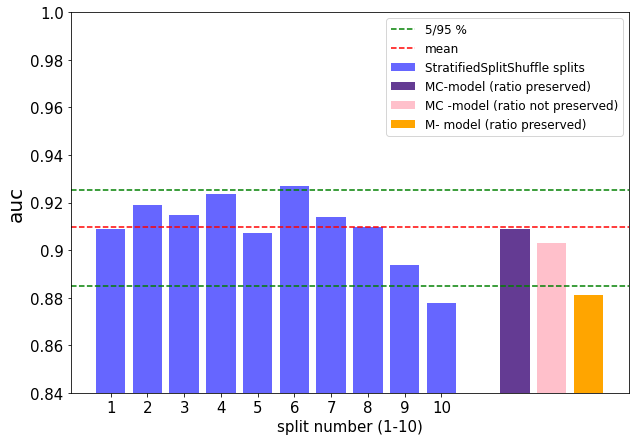

In [13]:
fig = plt.figure(figsize=(10, 7))
mosaic = fig.subplot_mosaic('''
                            a
                            ''')
# stratified sampling
mosaic['a'].bar(range(1, len(auc10) + 1), auc10, color='blue', alpha=0.6, label = 'StratifiedSplitShuffle splits')
mosaic['a'].bar(x = 12, height = aucC1, color = plt.cm.PuOr(0.9), alpha = 0.9, label = 'MC-model (ratio preserved)')
# mosaic['a'].bar(x = 13, height = initial_auc, color = 'pink', label = 'initial (old) model (ratio was not preserved)')
mosaic['a'].bar(x = 13, height = aucReg1, color = 'pink', label = 'MC -model (ratio not preserved)')

mosaic['a'].axhline(y=np.percentile(auc10, 95), color='green', linestyle = '--', label = '5/95 %')
mosaic['a'].axhline(y=np.percentile(auc10, 5), color='green', linestyle = '--')
mosaic['a'].axhline(y=np.mean(auc10), color = 'red', linestyle = '--', label = 'mean')

mosaic['a'].bar(x = 14, height = 0.881, color = 'orange', label = 'M- model (ratio preserved)')


# # regular sampling
# mosaic['b'].bar(range(1, len(aucReg10) + 1), aucReg10, color='blue', alpha=0.7, label = 'SplitShuffle split')
# # mosaic['b'].bar(x = 12, height = aucC1, color = 'orange', label = 'new model with ')
# mosaic['b'].bar(x = 13, height = aucReg1, color = 'pink', label = 'MC-model (ratio was not preserved)')

# mosaic['b'].axhline(y=np.percentile(aucReg10, 95), color='green', linestyle = '--', label = '5/95 %')
# mosaic['b'].axhline(y=np.percentile(aucReg10, 5), color='green', linestyle = '--')
# mosaic['b'].axhline(y=np.mean(aucReg10), color = 'red', linestyle = '--', label = 'mean')



mosaic['a'].set_ylim(0.84, 1) 
# mosaic['b'].set_ylim(0.84, 1) 
mosaic['a'].legend(fontsize=12)
# mosaic['b'].legend(fontsize=12)


# mosaic['a'].set_title('StratifiedShuffleSplit: the proportion of data points \n of class 1/0 is preserved, when splitting the data', fontsize = 15)
# mosaic['b'].set_title('ShuffleSplit: the data is split randomly', fontsize = 15)

mosaic['a'].set_xticks(range(1, len(aucReg10) + 1))#, fontsize = 20)
# mosaic['b'].set_xticks(range(1, len(aucReg10) + 1))#, fontsize = 20)
mosaic['a'].set_xticklabels(range(1, len(aucReg10) + 1), fontsize=15)
# mosaic['b'].set_xticklabels(range(1, len(aucReg10) + 1), fontsize=15)


mosaic['a'].set_ylabel('auc', fontsize = 15)
# mosaic['b'].set_ylabel('auc', fontsize = 15)


mosaic['a'].set_xlabel('split number (1-10)', fontsize = 15)
# mosaic['b'].set_xlabel('split number (1-10)', fontsize = 15)



mosaic['a'].set_ylabel('auc', fontsize = 20)
# mosaic['b'].set_ylabel('auc', fontsize = 20)


mosaic['a'].set_xlabel('split number (1-10)', fontsize = 15)
# mosaic['b'].set_xlabel('split number (1-10)', fontsize = 15)

mosaic['a'].set_yticklabels(labels=np.round(np.arange(0.84, 1.02, 0.02), 2), fontsize=15)
# mosaic['b'].set_yticklabels(labels=np.round(np.arange(0.84, 1.02, 0.02), 2), fontsize=15)


# 
# plt.savefig('out/removed_points/StratifiedShuffleSplit_together_with_morph_main_text_paper.png', dpi = 300, bbox_inches = 'tight')
# plt.savefig('/Users/varyabazilova/Desktop/alluvial_fans/reviews/out/removed_points/plots_for_paper/StratifiedShuffleSplit_together_with_morph_main_text_paper.png', dpi = 300, bbox_inches = 'tight')

# save new predictions

In [14]:
# make predictions 
model = modelC1[0]

y_result = model.predict(X)
probs = model.predict_proba(X)
probs = probs[:,1]


# calculate confusions 

df['y_result'] = y_result
df['y_result_probs'] = probs

df['result_True'] = df.target + df.y_result # TP = 2, TN = 0


# this is the column to see the "confusuon" situations
# TP = 2, TN = 0
# FP = -1, FN = 1
df['diff_res'] = np.where(df.result_True != 1, df.result_True, (df.target - df.y_result)) 

# Then, create a new column 'confusion' based on the condition 'diff_res' == 1
df['confusion'] = np.where(df['diff_res'] == 1, 'FN',  # False Negative
                           np.where(df['diff_res'] == 2, 'TP',  # True Positive
                                    np.where(df['diff_res'] == -1, 'FP',  # False Positive
                                             np.where(df['diff_res'] == 0, 'TN', 'Unknown'))))  # True Negative and Unknown

# save predictions
# df.to_csv('out/removed_points/20240711_new_model_predictions_output.csv')

# test what will happen if i remove all the glaciers 
# df.to_csv('out/removed_points/20240711_new_model_predictions_output_test_no_glaciers.csv')

In [15]:
df.target.value_counts()

1    1063
0     730
Name: target, dtype: int64

In [16]:

correct = 992 + 645
wrong = 93 + 76

total = len(df)

percent_correct = correct /total 
percent_wrong = wrong / total

print('fraction of wrong classification:', np.round((percent_wrong * 100),2))

fraction of wrong classification: 9.43


In [ ]:
accuracyC1

# model meaning (shap etc)
- shap overall 
- shap per big region

In [17]:
outpath = '/Users/varyabazilova/Desktop/alluvial_fans/reviews/'
df_predict = pd.read_csv(outpath+'out/removed_points/20240711_new_model_predictions_output.csv', index_col = 0)


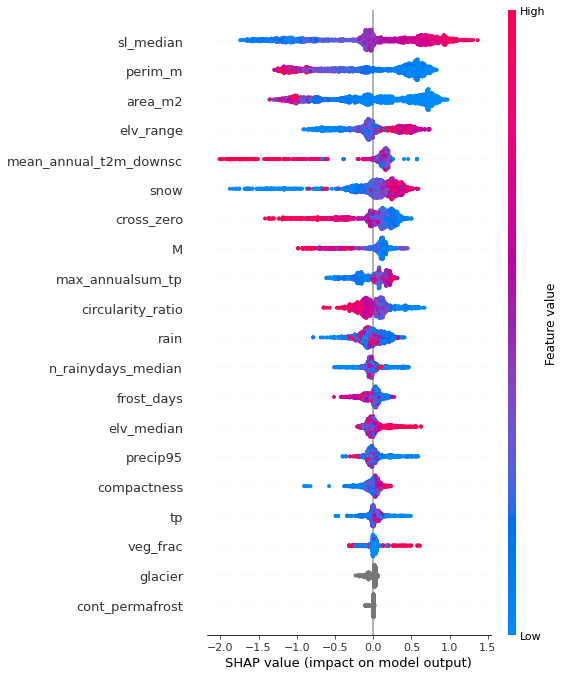

In [18]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=21, show=False)


In [19]:
# shap.summary_plot(shap_values, X, show=False, cmap=cut_cmap, max_display = 8,plot_size=(10, 7))


features = ['median slope', 'perimeter','area','relief',  
            'mean annual temperature', 'snowfall', 'thermal weathering', 'Melton ratio', 
            'max annual precipitation',
            'circularity ratio', 
            'rainfall',
            'N of wet days',
            'frost weathering',
            'median elevation',
            '95% precipitation',
            'compactness',  
            'total precipitation', 'vegetation cover (%)', 'glacier', 'continious permafrost'] # 1 purple

my_colors = ['orange', 'orange','orange','orange',  
            'purple', 'purple', 'purple', 
            'orange', 
            'purple',
            'orange', 
            'purple',
            'purple',
            'purple',
            'orange',
            'purple',
            'orange',  
            'purple', 'purple', 'purple', 'purple'] # 1 purple

features = ['median slope', 'perimeter','area','relief',  
            'mean annual temperature', 'snowfall', 'thermal weathering', 'Melton ratio']


purple = plt.cm.PuOr(0.9)
orange = plt.cm.PuOr(0.125)



my_colors = [orange, orange,orange,orange,  
            purple, purple, purple, orange]

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('bone_r')
cut_cmap = truncate_colormap(cmap, 0.1, 1)

(array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 [Text(-2.5, 0, '−2.5'),
  Text(-2.0, 0, '−2.0'),
  Text(-1.5, 0, '−1.5'),
  Text(-1.0, 0, '−1.0'),
  Text(-0.5, 0, '−0.5'),
  Text(0.0, 0, '0.0'),
  Text(0.5, 0, '0.5'),
  Text(1.0, 0, '1.0'),
  Text(1.5, 0, '1.5'),
  Text(2.0, 0, '2.0')])

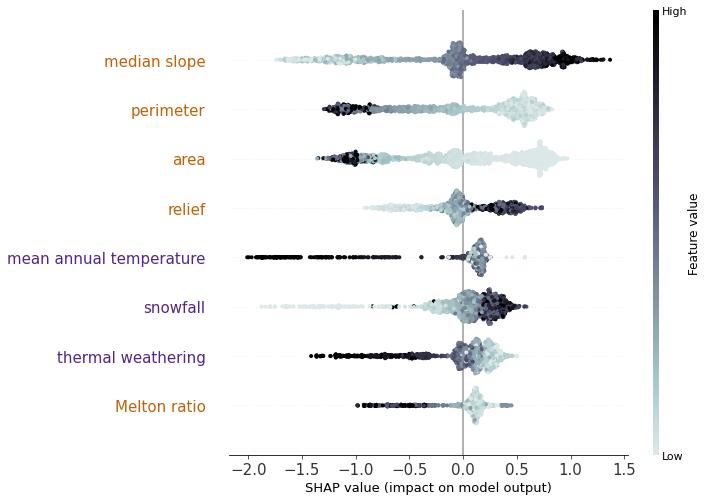

In [20]:

features = ['median slope', 'perimeter','area','relief',  
            'mean annual temperature', 'snowfall', 'thermal weathering', 'Melton ratio']

my_colors = [orange, orange,orange,orange,  
            purple, purple, purple, orange]
# shap.summary_plot(shap_values, X, show=False, cmap=cut_cmap, plot_size=(10, 12))

shap.summary_plot(shap_values, X, show=False, cmap=cut_cmap, max_display = 8,plot_size=(10, 7))


# color and rename labels 
for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), my_colors[::-1]):
    ticklabel.set_color(tickcolor)

plt.yticks(range(len(features)), features[::-1], fontsize=15)
# plt.yticks(range(len(features)), features, fontsize=15) # this is upside down
plt.xticks(fontsize=15)

# plt.savefig('out/removed_points/Cmodel_first8_shap_summaryplot.png', dpi = 300, bbox_inches = 'tight')

In [21]:
# SAVE SHAP 
shapdf = pd.DataFrame(shap_values, columns=X.columns)
shapdf = shapdf.abs()
shapdf['region'] = df['region']

# Apply the function to create the new column
shapdf['big_region'] = shapdf.apply(functions.categorize_region, axis=1)
shapdf_mean = shapdf.groupby('big_region').mean()


In [22]:


shapdf['big_region'].value_counts()


West        700
Interior    455
East        271
South       192
North       175
Name: big_region, dtype: int64

# clean up plot per region

In [23]:
# make colors: 

x = np.arange(0, 9, 1)
browns = x/(x.max()*2)

x2 = np.arange(1, 13, 1)
purples = x2/(x2.max()*2) + 0.5

x_combined = np.hstack([browns[:-1], purples])

colors = []
for i in x_combined:
    col = plt.cm.PuOr(i)
    colors.append(col)

# colors for each column
column_colors = {
    '(1) median elevation': colors[0], 
    '(2) relief': colors[1], 
    '(3) area': colors[2], 
    '(4) perimeter': colors[3], 
    '(5) median slope': colors[4],
    '(6) Melton ratio': colors[5], 
    '(7) circularity ratio': colors[6], 
    '(8) compactness': colors[7],
    '(9) total annual precipitation': colors[8], 
    '(10) max annual precipitation': colors[9],
    '(11) N of wet days': colors[10], 
    '(12) 95% precipitation': colors[11], 
    '(13) snowfall': colors[12], 
    '(14) rainfall': colors[13],
    '(15) mean annual temperature': colors[14], 
    '(16) thermal weathering': colors[15], 
    '(17) frost weathering': colors[16],
    '(18) vegetation cover (%)': colors[17],
    '(19) continious permafrost': colors[18], 
    '(20) glacier': colors[19]
}


# organize data for plotting  
df = shapdf_mean

df = functions.reorder_columns_for_colors(df)
df = functions.rename_columns_for_colors(df)



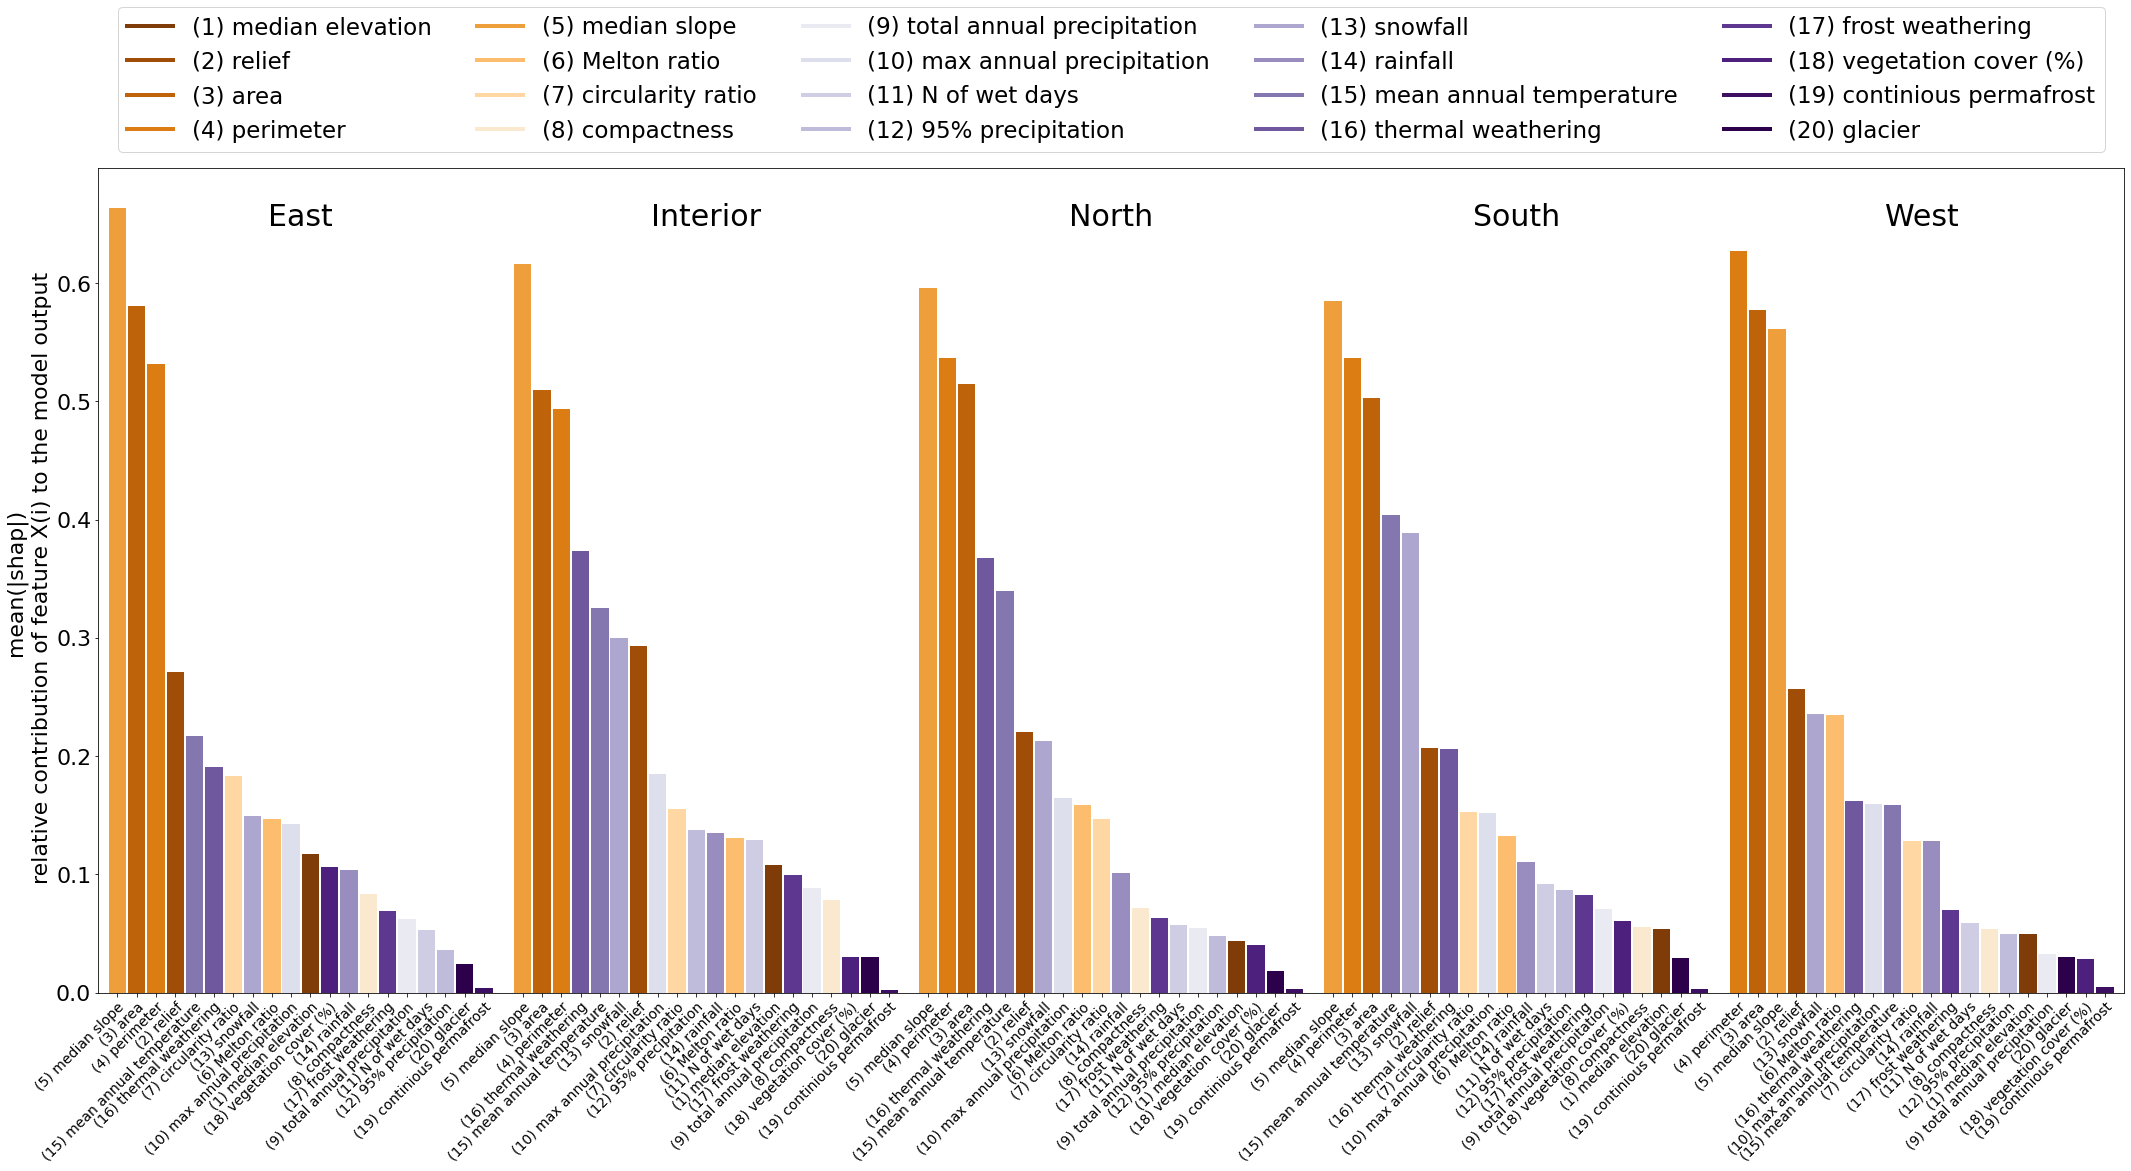

In [24]:
flattened = df.stack().reset_index()
flattened.columns = ['Row', 'Column', 'Value']
sorted_flattened = flattened.groupby('Row').apply(lambda x: x.sort_values(by='Value', ascending=False)).reset_index(drop=True)

# Add gaps to the index
gap_size = 1 # Number of gaps between groups
new_index = []
new_labels = []

for i, (row, group) in enumerate(sorted_flattened.groupby('Row')):
    start_index = i * (len(group) + gap_size)
    end_index = start_index + len(group)
    new_index.extend(range(start_index, end_index))
    new_labels.extend([col for col in group['Column']])
    # new_labels.extend([f"{row}-{col}" for col in group['Column']])


sorted_flattened.index = new_index

# Define the size of the figure
plt.figure(figsize=(30, 17))

# Set the width of the bars
bar_width = 0.9  # Adjust this value as needed

# Plot the data with adjusted bar positions
bars = plt.bar(sorted_flattened.index, sorted_flattened['Value'], width=bar_width,
               color=[column_colors[col] for col in sorted_flattened['Column']])

# Create custom legend
legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in column_colors.values()]
# plt.legend(legend_handles, column_colors.keys(), fontsize=15, bbox_to_anchor=(0.92, 0.85))

# plt.legend(legend_handles, column_colors.keys(), fontsize=15, loc='upper right', bbox_to_anchor=(1.05, 0.9))  # Adjusted value
# loc="lower right",ncol=4)

plt.legend(legend_handles, column_colors.keys(), fontsize=23, loc='upper center', ncol = 5, bbox_to_anchor=(0.5, 1.21))  


plt.ylabel('mean(|shap|) \n relative contribution of feature X(i) to the model output', fontsize=22)



rotation = 45

if rotation == 0:
    ha = 'center'
    va = 'top'
elif rotation == 90:
    ha = 'right'
    va = 'top'
else:
    ha = 'right'
    va = 'top'

plt.xticks(ticks=new_index, labels=new_labels, rotation=rotation, ha='right', rotation_mode='anchor', fontsize = 14)
plt.yticks(fontsize=22)

# Adjust margins to reduce space on the sides
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)

# Adjust x-axis limits to leave more space on the sides
plt.xlim(sorted_flattened.index.min() - 1, sorted_flattened.index.max() + 1)

plt.tight_layout()
# plt.show()

group_labels = ['East', 'Interior', 'North', 'South', 'West']
# group_labels = ['one', 'two', 'three', 'four']
# Determine the y position for the labels to align them horizontally
max_height = sorted_flattened['Value'].max()
label_y_position = max_height - 0.02  # Adjust this value if needed

for i, (row, group) in enumerate(sorted_flattened.groupby('Row')):
    start_index = i * (len(group) + gap_size)
    end_index = start_index + len(group) - 1

    plt.text((start_index + end_index) / 2, label_y_position, group_labels[i % len(group_labels)], 
             ha='center', va='bottom', fontsize=30)

# plt.savefig('out/removed_points/sorted_shap_barchart_per_big_region.png', dpi = 300, bbox_inches = 'tight')

# pie charts with the contribution 

In [25]:
morphometry_part = ['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median', 
                    'M', 'circularity_ratio', 'compactness']

climate_part = ['max_annualsum_tp', 'n_rainydays_median', 'precip95', 'cross_zero',
                'frost_days', 'tp', 'snow', 'rain', 'veg_frac','mean_annual_t2m_downsc',
                'cont_permafrost', 'glacier']


morphometry_part = shapdf_mean[morphometry_part]
climate_part = shapdf_mean[climate_part]

In [26]:
morphometry_part = morphometry_part.T
morphometry_sum = morphometry_part.sum()

climate_part = climate_part.T
climate_sum = climate_part.sum()

In [27]:
totalshap = pd.DataFrame()
totalshap['morph'] = morphometry_sum
totalshap['clim'] = climate_sum

In [28]:
# totalshap['total'] = totalshap.morph + totalshap.clim

totalshap2 = totalshap.T
totalshap2

big_region,East,Interior,North,South,West
morph,2.579512,2.385142,2.288593,2.225661,2.489190
clim,1.159355,1.836440,1.471590,1.686800,1.119345


<AxesSubplot:ylabel='West'>

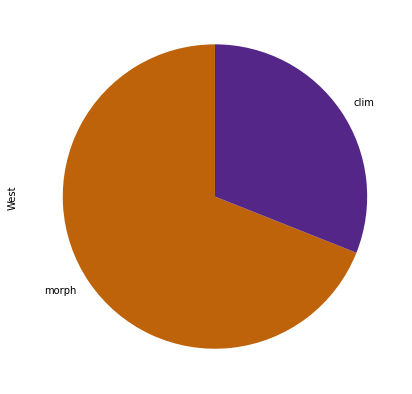

In [29]:
totalshap2.West.plot.pie(figsize=(7,7), colors = [orange, purple],startangle = 90 )
# plt.savefig('out/removed_points/shap_pie_west.png', dpi = 300, bbox_inches = 'tight')

In [30]:
totalshap['total'] = totalshap.morph + totalshap.clim

totalshap['clim_frac'] = totalshap.clim * 100 / totalshap.total

In [82]:
totalshap.describe()

,morph,clim,total,clim_frac
count,5.000000,5.000000,5.000000,5.000000
mean,2.393620,1.454706,3.848326,37.555692
std,0.144051,0.316059,0.234885,6.211477
min,2.225661,1.119345,3.608535,31.008192
25%,2.288593,1.159355,3.738867,31.019382
50%,2.385142,1.471590,3.760183,39.136133
75%,2.489190,1.686800,3.912461,43.113529
max,2.579512,1.836440,4.221581,43.501223


# plot with confusion per probebility bin

In [32]:
# outpath = '/Users/varyabazilova/Desktop/alluvial_fans/reviews/'
# df_predict = pd.read_csv(outpath+'out/removed_points/20240711_new_model_predictions_output.csv', index_col = 0)


# decode correct and wrong to 1 and 0
df_predict = pd.read_csv(outpath + 'out/20240605_new_model_predictions_output.csv', index_col = 0)

# bin the probability for the plot
bin_labels = []
for i in range(0, 100, 5):
    label = f"{i}-{i+5}"
    bin_labels.append(label)

col_wr = plt.cm.bone(1/8)
col_correct = plt.cm.bone(7/8)

In [33]:
df_predict['quality'] = df_predict.confusion.apply(functions.determine_class)

df_predict['bin'] = df_predict.y_result_probs.apply(functions.determine_probability_bin)
df_predict['order'] = df_predict.y_result_probs.apply(functions.determine_order_for_bins_plot)


In [34]:
# filter
correct = df_predict[df_predict.quality == 1].groupby(['order']).count()['quality']
wrong = df_predict[df_predict.quality == 0].groupby(['order']).count()['quality']


In [35]:
alltogether = pd.DataFrame()
alltogether['correctly classified'] = correct
alltogether['wrongly classified'] = wrong
alltogether['total'] = alltogether['correctly classified'] + alltogether['wrongly classified']
alltogether['percent_correct'] = (alltogether['correctly classified'] * 100) / alltogether.total
alltogether['percent_wrong'] = (alltogether['wrongly classified'] * 100) / alltogether.total

alltogether.sort_values('percent_wrong', ascending = False)

,correctly classified,wrongly classified,total,percent_correct,percent_wrong
order,,,,,
35,19,17,36,52.777778,47.222222
55,12,10,22,54.545455,45.454545
45,18,12,30,60.000000,40.000000
50,17,11,28,60.714286,39.285714
65,25,14,39,64.102564,35.897436
40,27,14,41,65.853659,34.146341
30,26,11,37,70.270270,29.729730
60,29,12,41,70.731707,29.268293
75,39,10,49,79.591837,20.408163


In [36]:

forplot = pd.DataFrame()
forplot['correctly classified'] = alltogether.percent_correct
forplot['wrongly classified'] = alltogether.percent_wrong




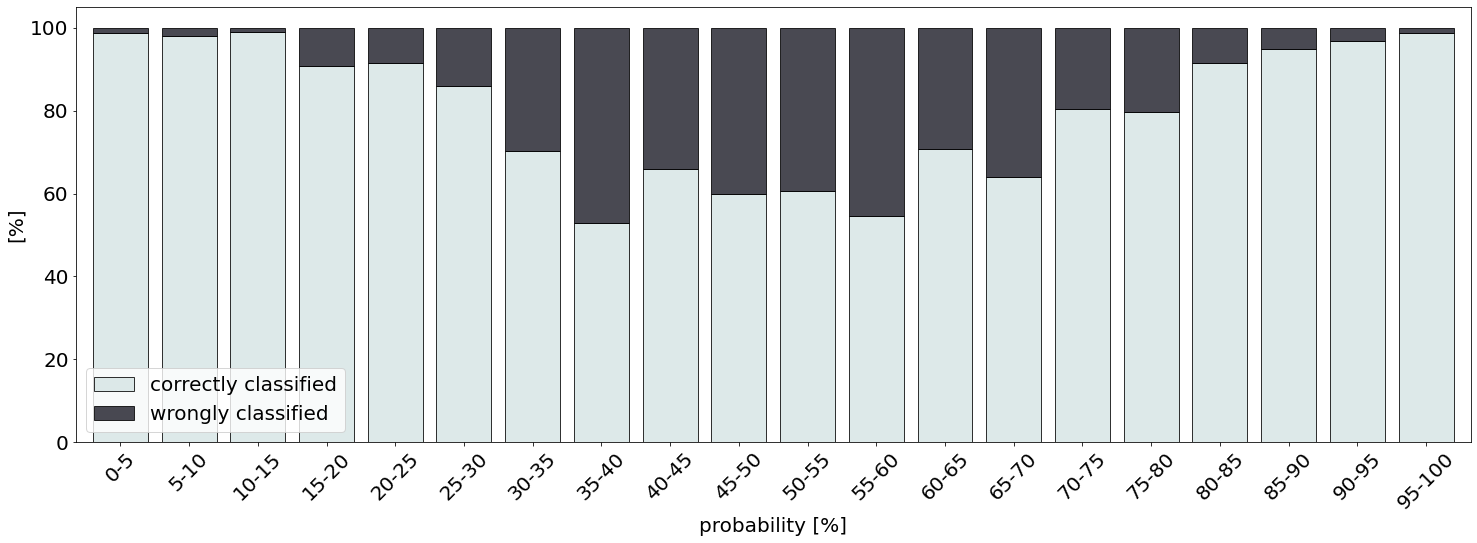

In [37]:
plt.rcParams.update({'font.size': 20})

colors = [col_correct, col_wr]

# filter
# forplot = alltogether[['correctly classified', 'wrongly classified']]
# forplot = alltogether[['percent_correct', 'percent_wrong']]

# plot
fig, ax = plt.subplots()
forplot.plot.bar(figsize = (25, 8),  alpha = 0.8, rot=45, width=0.8, 
                                                          stacked=True, edgecolor = 'black', ax=ax, color = colors)


plt.xticks(range(len(bin_labels)), bin_labels, rotation=45)  # Set the x-axis labels
plt.ylabel('[%]')
plt.xlabel('probability [%]')
# plt.xlabel('[%]')
plt.show()


# fig.savefig('out/barplot_wrong_correct_with_percent.png', dpi = 300, bbox_inches = 'tight')#, transparent = True)


# correlations between features 

In [38]:
# feature correlation:

X = functions.reorder_columns_for_colors(X)
X = functions.rename_columns_for_colors(X)
X['target'] = climate.target

x_columns = X.columns 



In [39]:
# X

In [40]:
# X['(19) continious permafrost']

In [41]:
# X['(20) glacier'].astype(int)
X['(20) glacier'] = X['(20) glacier'].astype(int)
X['(19) continious permafrost'] = X['(19) continious permafrost'].astype(int)

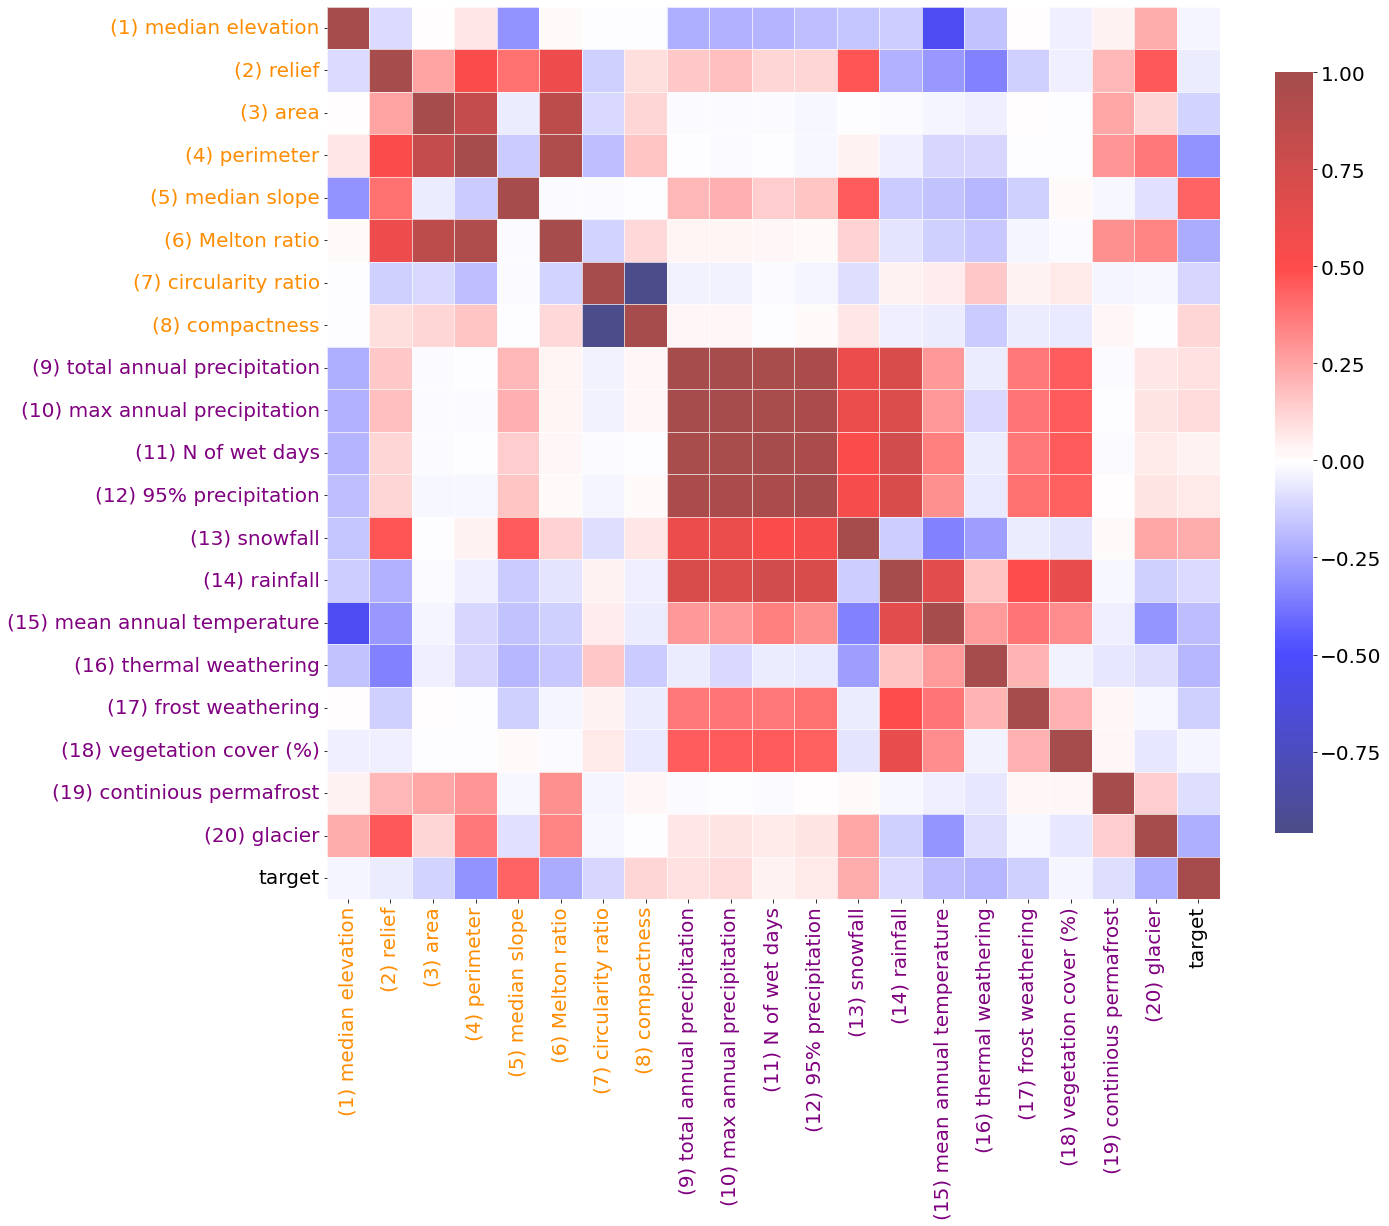

In [42]:
def correlation_heatmap(X):
    correlations = X.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    heatmap = sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="seismic", alpha = 0.7,
                          square=True, linewidths=.5, annot=False, cbar_kws={"shrink": .70})
    
    # Get the current tick labels
    labels = heatmap.get_yticklabels()
    
    # Color the first 5 labels orange, the rest purple
    for label in labels[:8]:
        label.set_color('darkorange')
    for label in labels[8:]:
        label.set_color('purple')
    for label in labels[-1:]:
        label.set_color('black')
    
    heatmap.set_yticklabels(labels)
    heatmap.set_yticklabels(labels)
    
    # Get the current tick labels
    labels = heatmap.get_xticklabels()
    
    # Color the first 5 labels orange, the rest purple
    for label in labels[:8]:
        label.set_color('darkorange')
    for label in labels[8:]:
        label.set_color('purple')
    for label in labels[-1:]:
        label.set_color('black')
    
    heatmap.set_xticklabels(labels)
    heatmap.set_xticklabels(labels)

    # plt.show()
correlation_heatmap(X[x_columns])


# plt.savefig('out/removed_points/correlation_matrix_all_features.png', dpi = 300, bbox_inches = 'tight')

In [43]:
X.columns

Index(['(1) median elevation', '(2) relief', '(3) area', '(4) perimeter',
       '(5) median slope', '(6) Melton ratio', '(7) circularity ratio',
       '(8) compactness', '(9) total annual precipitation',
       '(10) max annual precipitation', '(11) N of wet days',
       '(12) 95% precipitation', '(13) snowfall', '(14) rainfall',
       '(15) mean annual temperature', '(16) thermal weathering',
       '(17) frost weathering', '(18) vegetation cover (%)',
       '(19) continious permafrost', '(20) glacier', 'target'],
      dtype='object')

# histograms for data

In [44]:
#define functions to make scales for a plot: 

#### LOG SCALE ####
def make_log_x_scale(data, column, ax):
    ax.hist(data[data.target==0][column].apply(np.log10), bins=20, color=ff_color, alpha = 0.5
           , weights=100*np.ones(len(data[data.target==0])) / len(data[data.target==0]))
    ax.hist(data[data.target==1][column].apply(np.log10), bins=20, color=df_color, alpha=0.5
            , weights=100*np.ones(len(data[data.target==1])) / len(data[data.target==1]))
    ax.set_xlabel(f'log({column})')
    ax.set_ylabel('[%]')


#### LINEAR SCALE ####
def make_linear_x_scale(data, column, ax):
    ax.hist(data[data.target==0][column], bins=20, color=ff_color, alpha = 0.5#, edgecolor='black', alpha = 0.5#, label='FF'
            , weights=100*np.ones(len(data[data.target==0])) / len(data[data.target==0]))
    
    ax.hist(data[data.target==1][column], bins=20, color=df_color,  alpha = 0.5#, edgecolor='black', alpha=0.25#, label='DF'
           , weights=100*np.ones(len(data[data.target==1])) / len(data[data.target==1]))
    # ax.legend()
    ax.set_ylabel('[%]')
    ax.set_xlabel(f'{column}')

    
ff_color = plt.cm.Set1(1/8)
df_color = plt.cm.Set1(0/8)

In [45]:
together = pd.read_csv('/Users/varyabazilova/Desktop/alluvial_fans/final/!!_050723_cathments_data.csv', index_col = 0)
together = together[together['area_m2'] > 1000]


together = together.drop(['x_wgs', 'y_wgs', 'id'], axis = 1)


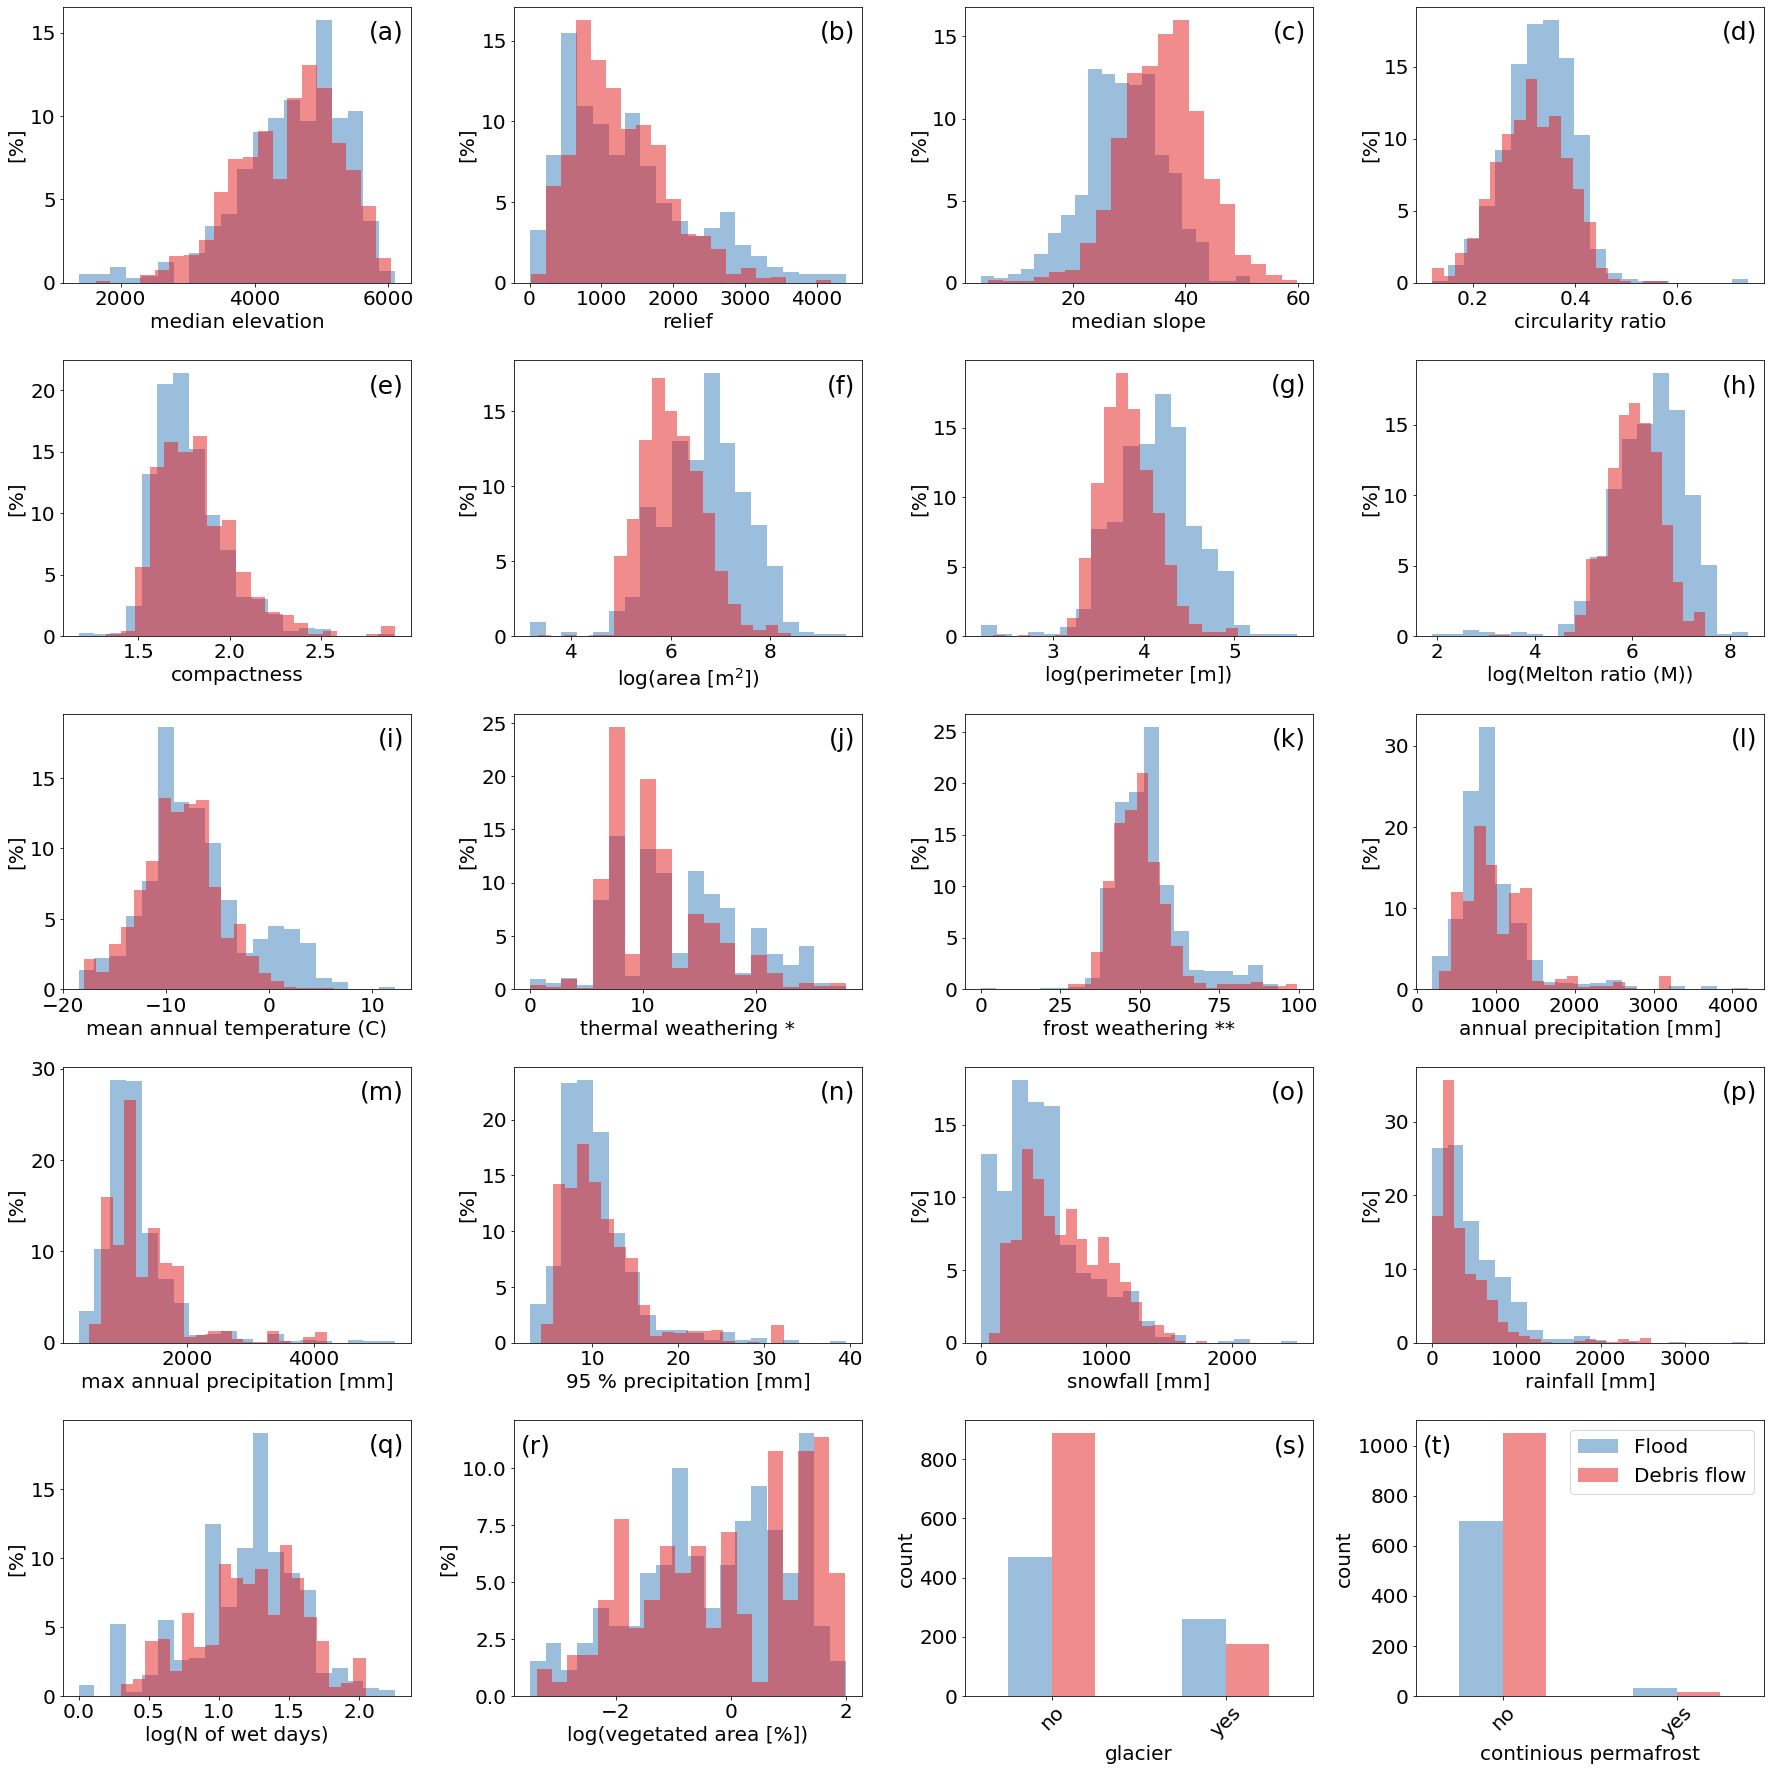

In [46]:
# Plot with Mosaic

plt.rcParams.update({'font.size': 20})



fig = plt.figure(figsize=(25, 25))
mosaic = fig.subplot_mosaic('''
                            2345
                            6789
                            jklm
                            nopq
                            rstu
                            ''')

# ------ morphometric: 

# normal scale-=
make_linear_x_scale(data=together, column='elv_median',        ax=mosaic['2'])
mosaic['2'].set(xlabel="median elevation")
make_linear_x_scale(data=together, column='elv_range',         ax=mosaic['3'])
mosaic['3'].set(xlabel="relief")
make_linear_x_scale(data=together, column='sl_median',         ax=mosaic['4'])
mosaic['4'].set(xlabel="median slope")
make_linear_x_scale(data=together, column='circularity_ratio', ax=mosaic['5'])
mosaic['5'].set(xlabel="circularity ratio")
make_linear_x_scale(data=together, column='compactness',       ax=mosaic['6'])
mosaic['6'].set(xlabel="compactness")

# log scale
make_log_x_scale(data=together, column='area_m2', ax=mosaic['7'])
mosaic['7'].set(xlabel="log(area [m$^2$])")
make_log_x_scale(data=together, column='perim_m', ax=mosaic['8'])
mosaic['8'].set(xlabel="log(perimeter [m])")
make_log_x_scale(data=together, column='M',       ax=mosaic['9'])
mosaic['9'].set(xlabel="log(Melton ratio (M))")


# mark with *
# mosaic['2'].scatter([10], [13.5],   marker = 'o', s = 1000, facecolors= plt.cm.PuOr(2.1/8), edgecolors='none') 
# mosaic['3'].scatter([10], [13.5],   marker = 'o', s = 1000, facecolors= plt.cm.PuOr(2.1/8), edgecolors='none') 
# mosaic['4'].scatter([0], [13.5],    marker = 'o', s = 1000, facecolors= plt.cm.PuOr(2.1/8), edgecolors='none') 
# mosaic['5'].scatter([0.1], [17.1],  marker = 'o', s = 1000, facecolors= plt.cm.PuOr(2.1/8), edgecolors='none') 
# mosaic['6'].scatter([1.1], [19],    marker = 'o', s = 1000, facecolors= plt.cm.PuOr(2.1/8), edgecolors='none') 
# mosaic['7'].scatter([2.5], [16.2],  marker = 'o', s = 1000, facecolors= plt.cm.PuOr(2.1/8), edgecolors='none') 
# mosaic['8'].scatter([2], [18.2],    marker = 'o', s = 1000, facecolors= plt.cm.PuOr(2.1/8), edgecolors='none') 
# mosaic['9'].scatter([1], [18],      marker = 'o', s = 1000, facecolors= plt.cm.PuOr(2.1/8), edgecolors='none') 





# ------ climate: 
'''
'max_annualsum_tp', 'n_rainydays_median', 'precip95', 'cross_zero',
       'frost_days', 'tp', 'snow', 'rain', 'veg_frac',
       'mean_annual_t2m_downsc', 'cont_permafrost', 'glacier'],'''

# normal scale
# temp
make_linear_x_scale(data=together, column='mean_annual_t2m_downsc', ax=mosaic['j'])
mosaic['j'].set(xlabel="mean annual temperature (C)")
make_linear_x_scale(data=together, column='cross_zero',             ax=mosaic['k'])
mosaic['k'].set(xlabel="thermal weathering *")
make_linear_x_scale(data=together, column='frost_days',             ax=mosaic['l'])
mosaic['l'].set(xlabel="frost weathering **")


# precip
make_linear_x_scale(data=together, column='tp',                     ax=mosaic['m'])
mosaic['m'].set(xlabel="annual precipitation [mm]")
make_linear_x_scale(data=together, column='max_annualsum_tp',       ax=mosaic['n'])
mosaic['n'].set(xlabel="max annual precipitation [mm]")
make_linear_x_scale(data=together, column='precip95',               ax=mosaic['o'])
mosaic['o'].set(xlabel="95 % precipitation [mm]")
make_linear_x_scale(data=together, column='snow',                   ax=mosaic['p'])
mosaic['p'].set(xlabel="snowfall [mm]")
make_linear_x_scale(data=together, column='rain',                   ax=mosaic['q'])
mosaic['q'].set(xlabel="rainfall [mm]")


# log scale
make_log_x_scale(data=together, column='n_rainydays_median',            ax=mosaic['r'])
mosaic['r'].set(xlabel="log(N of wet days)")
make_log_x_scale(data=together[together.veg_frac>0], column='veg_frac', ax=mosaic['s'])
mosaic['s'].set(xlabel="log(vegetated area [%])")



### glaciers ####
g0 = together[together.target==0].groupby(['glacier']).count()['target']
g1 = together[together.target==1].groupby(['glacier']).count()['target']
pd.DataFrame({'FF':g0, 'DF':g1}).plot.bar(ax=mosaic['t'], color=[ff_color, df_color], alpha = 0.5, legend=False)
mosaic['t'].set_xticklabels(['no', 'yes'], rotation = 45)
mosaic['t'].set(ylabel="count")


### permafrost ####
p0 = together[together.target==0].groupby(['cont_permafrost']).count()['target']
p1 = together[together.target==1].groupby(['cont_permafrost']).count()['target']
pd.DataFrame({'FF':p0, 'DF':p1}).plot.bar(ax=mosaic['u'], color=[ff_color, df_color], alpha = 0.5)
mosaic['u'].set(xlabel="continious permafrost")
mosaic['u'].set_xticklabels(['no', 'yes'], rotation = 45)
mosaic['u'].set(ylabel='count')
mosaic['u'].legend(["Flood", "Debris flow"])


# Define labels for each subplot
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)',
          '(j)', '(k)', '(l)', '(m)', '(n)', '(o)', '(p)', '(q)', '(r)', 
          '(s)', '(t)']


# Add labels to each subplot
for i, (key, ax) in enumerate(mosaic.items()):
    if i == len(mosaic) - 1 or i == len(mosaic) - 3:  # Check if it's the last or third from the end subplot
        ax.text(0.02, 0.95, labels[i], transform=ax.transAxes,
                fontsize=25, verticalalignment='top', horizontalalignment='left')
    else:
        ax.text(0.98, 0.95, labels[i], transform=ax.transAxes,
                fontsize=25, verticalalignment='top', horizontalalignment='right')


fig.tight_layout()



# SAVE THIS FIGURE, CHANGE THE FONT SIZE 

# plt.savefig(outpath + 'out/removed_points/together_histograms.png', dpi = 300, bbox_inches = 'tight')


In [ ]:
# outpath

# probabilities vs predictor plots

In [49]:
df_predict = pd.read_csv(outpath+'out/removed_points/20240711_new_model_predictions_output.csv', index_col = 0)
df_predict.columns

Index(['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median', 'region',
       'max_annualsum_tp', 'n_rainydays_median', 'precip95', 'cross_zero',
       'frost_days', 'tp', 'snow', 'rain', 'veg_frac', 'target', 'M',
       'circularity_ratio', 'compactness', 'mean_annual_t2m_downsc',
       'cont_permafrost', 'glacier', 'y_result', 'y_result_probs',
       'result_True', 'diff_res', 'confusion'],
      dtype='object')

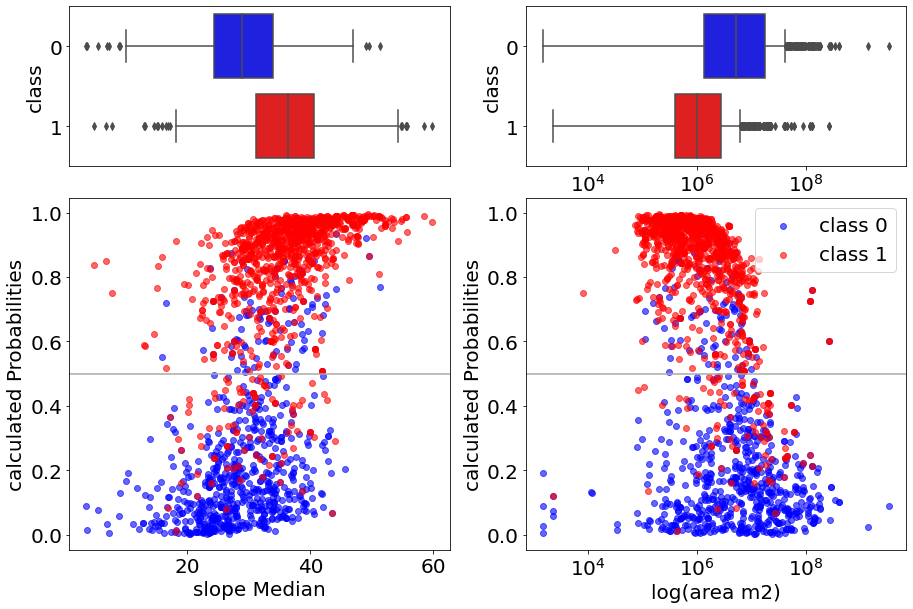

In [50]:
colors = {0: 'blue', 1: 'red'}

fig = plt.figure(figsize=(15, 10))

mosaic = fig.subplot_mosaic('''
                            ac
                            bd
                            bd
                            ''')

sns.boxplot(data=df_predict, x='sl_median', y='target',orient='h', ax =mosaic['a'], palette = ['blue', 'red'])
mosaic['a'].set_xticks([])
mosaic['a'].set_xlabel(' ')
mosaic['a'].set_ylabel('class')

# Define the colors

# Scatter plot
for target, color in colors.items():
    subset = df_predict[df_predict['target'] == target]
    mosaic['b'].scatter(subset['sl_median'], subset['y_result_probs'], c=color, label=f'Target {target}', alpha=0.6)
    
mosaic['b'].axhline(0.5, color = 'darkgrey')
# Adding labels and title
mosaic['b'].set_xlabel('slope Median')
mosaic['b'].set_ylabel('calculated Probabilities')
# plt.title('Scatter Plot of SL Median vs Result Probabilities')


sns.boxplot(data=df_predict, x='area_m2', y='target',orient='h', ax =mosaic['c'], palette = ['blue', 'red'])
mosaic['c'].set_xticks([])
mosaic['c'].set_xlabel(' ')
mosaic['c'].set_ylabel('class')

mosaic['c'].set_xscale('log')

# Scatter plot
for target, color in colors.items():
    subset = df_predict[df_predict['target'] == target]
    mosaic['d'].scatter(subset['area_m2'], subset['y_result_probs'], c=color, label=f'class {target}', alpha=0.6)
    
mosaic['d'].axhline(0.5, color = 'darkgrey')
mosaic['d'].set_xscale('log')
mosaic['d'].set_xlabel('log(area m2)')
mosaic['d'].set_ylabel('calculated Probabilities')

plt.legend()


# plt.savefig('out/removed_points/test_histograms.png', dpi = 300, bbox_inches = 'tight')

In [51]:
# 1806*0.7

In [52]:
1806-1264

542

In [53]:
df_predict

,elv_median,elv_range,area_m2,perim_m,sl_median,region,max_annualsum_tp,n_rainydays_median,precip95,cross_zero,...,circularity_ratio,compactness,mean_annual_t2m_downsc,cont_permafrost,glacier,y_result,y_result_probs,result_True,diff_res,confusion
0,3920.5,1266.0,1.129142e+06,6077.274,37.887260,Eastern Tien Shan,1179.64900,19.0,10.029156,20.0,...,0.384185,1.624822,-8.799016,0,1,1,0.812328,2,2,TP
1,3492.0,998.0,1.857044e+05,3047.855,44.832397,Eastern Tien Shan,1179.64900,19.0,10.029156,18.0,...,0.251214,2.009345,-6.013766,0,0,1,0.966605,2,2,TP
2,3772.5,1573.0,2.498432e+06,9109.876,39.817596,Eastern Tien Shan,1179.64900,19.0,10.029156,20.0,...,0.378314,1.637382,-7.837016,0,1,1,0.763113,2,2,TP
3,3797.0,1288.0,8.091939e+05,5903.452,43.148540,Eastern Tien Shan,1179.64900,19.0,10.029156,20.0,...,0.291777,1.864451,-7.996266,0,1,1,0.955118,2,2,TP
4,3768.0,1411.0,8.405174e+05,5391.403,41.112621,Eastern Tien Shan,1179.64900,19.0,10.029156,20.0,...,0.363373,1.670705,-7.807766,0,0,1,0.880215,2,2,TP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801,4493.5,1342.0,5.255777e+07,47146.427,23.860876,Western Pamir,535.16815,2.0,4.719082,8.0,...,0.297132,1.847573,-10.149556,0,1,0,0.016651,0,0,TN
1802,5239.0,2324.0,7.689677e+06,18976.706,40.180752,Karakoram,1234.54980,18.0,10.330390,0.0,...,0.268334,1.944187,-17.972284,0,1,1,0.798114,2,2,TP
1803,5159.0,2250.0,6.437386e+06,16449.628,38.776348,Karakoram,1234.54980,18.0,10.330390,0.0,...,0.298956,1.841927,-17.452284,0,1,1,0.831115,2,2,TP
1804,5440.0,3233.0,1.632257e+08,85444.870,35.609585,Karakoram,900.24207,9.0,7.735223,2.0,...,0.280948,1.900041,-17.447108,1,1,0,0.193739,0,0,TN


In [54]:
df.columns

Index(['(1) median elevation', '(2) relief', '(3) area', '(4) perimeter',
       '(5) median slope', '(6) Melton ratio', '(7) circularity ratio',
       '(8) compactness', '(9) total annual precipitation',
       '(10) max annual precipitation', '(11) N of wet days',
       '(12) 95% precipitation', '(13) snowfall', '(14) rainfall',
       '(15) mean annual temperature', '(16) thermal weathering',
       '(17) frost weathering', '(18) vegetation cover (%)',
       '(19) continious permafrost', '(20) glacier'],
      dtype='object')

# data describe 

In [61]:
df = pd.read_csv('/Users/varyabazilova/Desktop/alluvial_fans/final/!!_050723_cathments_data.csv', index_col = 0)
df = df[df['area_m2'] > 1000]


df = df.drop(['x_wgs', 'y_wgs', 'id'], axis = 1)

morphometry = ['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median', 
               'target', 'M', 'circularity_ratio', 'compactness']

climate = ['max_annualsum_tp', 'n_rainydays_median', 'precip95', 'cross_zero',
           'frost_days', 'tp', 'snow', 'rain', 'target', 'mean_annual_t2m_downsc']

morphometry = df[morphometry]
climate = df[climate]


In [62]:
morphometry_df = morphometry[morphometry['target'] == 1]
morphometry_ff = morphometry[morphometry['target'] == 0]

morphometry_df = functions.rename_columns_morph(morphometry_df)
morphometry_ff = functions.rename_columns_morph(morphometry_ff)

climate_df = climate[climate['target'] == 1]
climate_ff = climate[climate['target'] == 0]

climate_df = functions.rename_columns_clim(climate_df)
climate_ff = functions.rename_columns_clim(climate_ff)

morphometry_df = morphometry_df.drop(['target'], axis = 1)
morphometry_ff = morphometry_ff.drop(['target'], axis = 1)

climate_df = climate_df.drop(['target'], axis = 1)
climate_ff = climate_ff.drop(['target'], axis = 1)

In [63]:
morphometry_df = round(morphometry_df.describe(), 2)
morphometry_df = morphometry_df.drop(['count'], axis = 0)
# morphometry_df.to_csv('out/removed_points/morphometry_df.csv')

morphometry_ff = morphometry_ff.describe()
morphometry_ff = round(morphometry_ff.describe(), 2)
morphometry_ff = morphometry_ff.drop(['count'], axis = 0)
# morphometry_ff.to_csv('out/removed_points/morphometry_ff.csv')



climate_df = round(climate_df.describe(), 2)
climate_df = climate_df.drop(['count'], axis = 0)
# climate_df.to_csv('out/removed_points/climate_df.csv')

climate_ff = climate_ff.describe()
climate_ff = round(climate_ff.describe(), 2)
climate_ff =climate_ff.drop(['count'], axis = 0)
# climate_ff.to_csv('out/removed_points/climate_ff.csv')


In [80]:
morphometry_df

,median elevation,relief,area,perimeter,median slope,Melton ratio,circularity ratio,compactness
mean,4519.38,1270.10,4.211497e+06,8977.69,36.01,2343135.62,0.31,1.83
std,752.77,637.86,1.621544e+07,9867.57,7.26,3657274.17,0.07,0.23
min,1624.00,24.00,2.237400e+03,220.33,4.81,1135.23,0.12,1.32
25%,3985.00,798.00,3.993763e+05,4130.48,31.23,529008.63,0.27,1.66
50%,4639.00,1143.00,9.941523e+05,6229.85,36.30,1170644.71,0.31,1.80
75%,5068.75,1654.50,2.759090e+06,10322.16,40.61,2656543.41,0.37,1.95
max,6031.00,4191.00,2.627717e+08,110364.75,59.85,31512696.48,0.58,2.91


In [77]:
morphometry_ff

,median elevation,relief,area,perimeter,median slope,Melton ratio,circularity ratio,compactness
mean,3441.37,1376.88,4.418602e+08,73881.20,113.53,3.408616e+07,91.53,92.66
std,2130.43,1337.63,1.173639e+09,169080.98,249.54,8.366037e+07,257.98,257.52
min,730.00,2.00,7.300000e+02,159.32,3.59,7.724000e+01,0.07,0.20
25%,1232.47,705.06,1.010980e+06,5297.88,20.01,5.774431e+05,0.25,1.53
50%,4345.17,1031.69,1.159105e+07,17907.36,28.91,4.715369e+06,0.33,1.76
75%,4796.69,1474.18,5.481984e+07,27298.91,38.33,9.402240e+06,0.47,2.13
max,6099.00,4407.00,3.344155e+09,491412.13,730.00,2.407974e+08,730.00,730.00


In [66]:
climate_df

,max annual precipitation,N of wet days,95% precipitation,thermal weathering,frost weathering,total annual precipitation,snowfall,rainfall,mean annual temperature
mean,1321.88,23.41,10.93,11.13,50.12,1031.41,659.76,371.08,-8.61
std,617.97,20.53,4.79,4.41,9.59,482.71,323.60,380.33,3.73
min,439.81,2.00,3.99,0.00,27.50,286.20,68.37,0.00,-17.97
25%,896.12,9.50,8.01,8.00,44.00,725.91,392.73,163.83,-10.93
50%,1147.48,18.00,9.89,10.00,49.50,930.83,606.55,245.09,-8.54
75%,1566.69,32.50,12.74,14.00,53.50,1257.33,906.54,469.92,-6.42
max,4201.66,111.50,32.31,28.00,99.50,3221.25,1801.42,2596.81,6.28


In [67]:
climate_ff

,max annual precipitation,N of wet days,95% precipitation,thermal weathering,frost weathering,total annual precipitation,snowfall,rainfall,mean annual temperature
mean,1421.40,126.11,102.03,101.71,130.12,1147.27,678.79,805.62,87.42
std,1596.97,250.85,254.00,254.00,244.08,1264.30,775.92,1210.66,259.81
min,280.34,1.00,2.70,0.00,0.00,189.68,0.00,0.00,-18.47
25%,694.09,15.88,6.90,7.38,36.84,645.77,325.21,304.45,-8.44
50%,970.30,21.17,10.13,12.59,52.12,791.14,469.57,421.06,-5.70
75%,1237.40,65.50,18.63,19.75,66.03,984.35,661.26,632.05,6.89
max,5281.15,730.00,730.00,730.00,730.00,4198.73,2515.83,3748.57,730.00


# regional differences 

In [ ]:

df['big_region'] = df.apply(functions.categorize_region, axis=1)
df.columns

In [ ]:
df_reg = df.groupby('big_region').mean()
df_reg2 = df_reg.copy()

In [ ]:
precip = df_reg2[['tp', 'rain', 'snow']]
precip['rain_frac'] = precip.rain * 100 / precip.tp
precip['snow_frac'] = precip.snow * 100 / precip.tp




In [ ]:
precip

In [ ]:
dfnorth = df[df['big_region'] == 'North']
dfnorth.region.unique()

In [ ]:
dfwest = df[df['big_region'] == 'West']


In [ ]:
dfwest.target.value_counts()

# no glaciers experinent 


In [ ]:
# df_predict

In [ ]:
df_predict_glaciers = df_predict[df_predict['glacier'] == 1]


In [ ]:
df_predict_glaciers_change = df_predict_glaciers

df_predict_glaciers_change['glacier'] = df_predict_glaciers_change['glacier'].replace(1, 0)

In [ ]:
climate = ['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median',
           'max_annualsum_tp', 'n_rainydays_median', 'precip95', 'cross_zero',
           'frost_days', 'tp', 'snow', 'rain', 'veg_frac', 'target', 'M',
           'circularity_ratio', 'compactness', 'mean_annual_t2m_downsc',
           'cont_permafrost', 'glacier']


glaciers_changed = df_predict_glaciers_change[climate]

y = glaciers_changed.target
X = glaciers_changed.drop(columns=['target'])

# # # what values are categorical: 
X['glacier'] = X['glacier'].astype(str) 
X['cont_permafrost'] = X['cont_permafrost'].astype(str)
# X['region'] = X['region'].astype(str)

# cat_features = list(['cont_permafrost', 'glacier'])#, 'region'])


In [ ]:
# make predictions 
model = modelC1[0]

y_result_gl = model.predict(X)
probs_gl = model.predict_proba(X)
probs_gl = probs_gl[:,1]


# # calculate confusions 
df = glaciers_changed
df['y_result_gl'] = y_result_gl
df['y_result_probs_gl'] = probs_gl

df['result_True'] = df.target + df.y_result_gl # TP = 2, TN = 0


# this is the column to see the "confusuon" situations
# TP = 2, TN = 0
# FP = -1, FN = 1
df['diff_res'] = np.where(df.result_True != 1, df.result_True, (df.target - df.y_result_gl)) 

# Then, create a new column 'confusion' based on the condition 'diff_res' == 1
df['confusion_gl'] = np.where(df['diff_res'] == 1, 'FN',  # False Negative
                           np.where(df['diff_res'] == 2, 'TP',  # True Positive
                                    np.where(df['diff_res'] == -1, 'FP',  # False Positive
                                             np.where(df['diff_res'] == 0, 'TN', 'Unknown'))))  # True Negative and Unknown

# # save predictions
# # df.to_csv('out/removed_points/20240711_new_model_predictions_output.csv')

# # test what will happen if i remove all the glaciers 
# df.to_csv('out/removed_points/20240723_new_model_predictions_output_test_no_glaciers.csv')

In [ ]:
noglaciers = df[['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median',
                'max_annualsum_tp', 'n_rainydays_median', 'precip95', 'cross_zero',
                'frost_days', 'tp', 'snow', 'rain', 'veg_frac', 'target', 'M',
                'circularity_ratio', 'compactness', 'mean_annual_t2m_downsc',
                'cont_permafrost', 'glacier', 'y_result_gl', 'y_result_probs_gl']]


In [ ]:
yesglaciers = df_predict_glaciers[['y_result', 'y_result_probs']]

In [ ]:
together = noglaciers.join(yesglaciers)

In [ ]:
together['diff_in_prob'] = together.y_result_probs - together.y_result_probs_gl

In [ ]:
# Plotting the data
plt.figure(figsize=(35, 6))

# Plotting df1 data
sns.barplot(together.index, together['y_result_probs'], label='still glaciers', color='blue')

# # Plotting df2 data
sns.barplot(together.index, together['y_result_probs_gl'], label='no more glaciers', color='red')


In [ ]:
# Plotting the data
plt.figure(figsize=(35, 10))

# Plotting df1 data
# sns.barplot(data = together, x = together.index, y= together['diff_in_prob'], hue = together.target)
sns.barplot(data = together, x = together.index, y= together['diff_in_prob'], hue = together.target)


# increase in temperature experiment

In [ ]:
climate = ['elv_median', 'elv_range', 'area_m2', 'perim_m', 'sl_median',
           'max_annualsum_tp', 'n_rainydays_median', 'precip95', 'cross_zero',
           'frost_days', 'tp', 'snow', 'rain', 'veg_frac', 'target', 'M',
           'circularity_ratio', 'compactness', 'mean_annual_t2m_downsc',
           'cont_permafrost', 'glacier']


changed = df_predict[climate]
changed['mean_annual_t2m_downsc'] = changed.mean_annual_t2m_downsc + 2

y = changed.target
X = changed.drop(columns=['target'])


# predictions
model = modelC1[0]

y_result_temp = model.predict(X)
probs_temp = model.predict_proba(X)
probs_temp = probs_temp[:,1]


# # calculate confusions 
# df = changed
changed['y_result_temp'] = y_result_temp
changed['y_result_probs_temp'] = probs_temp


In [ ]:
old_temp = df_predict[['y_result', 'y_result_probs', 'target']]
new_temp = changed[['y_result_temp', 'y_result_probs_temp']]

temps = old_temp.join(new_temp)

temps['diff_in_prob'] = temps.y_result_probs - temps.y_result_probs_temp

In [ ]:
# Plotting the data
plt.figure(figsize=(35, 6))

# df5 = temps[temps.target == 0]
df5 = temps.sort_values('target').reset_index()

# Plotting df1 data
sns.barplot(df5.index, df5['y_result_probs'], hue=df5.target)

# # Plotting df2 data
sns.barplot(df5.index, df5['y_result_probs_temp'], hue=df5.target, palette=['red', 'green'])

plt.legend()

In [ ]:
df5

In [ ]:
# Plotting the data
plt.figure(figsize=(35, 10))

# Plotting df1 data
# sns.barplot(data = together, x = together.index, y= together['diff_in_prob'], hue = together.target)
sns.barplot(data = temps, x = temps.index, y= temps['diff_in_prob'], hue = temps.target)


In [ ]:
floods = temps[temps.target == 1]

floods['diff_in_prob'].mean()


# LDA things as a comparison 